In [5]:
import requests
import pandas as pd
import numpy as np
from gemini import data, engine, helpers
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from bitmex_backtest import Backtest
%matplotlib inline

In [2]:
def collect_funding(params_dict={'symbol': 'XBTUSD', 'count': '100', 'reverse': 'false', 'start': '0'}):
    # Update data from timestamp of last entry in file
    api_call_url = 'https://www.bitmex.com/api/v1/funding?_format=csv'
    filepath = 'data/Bitmex/funding.csv'
    # Check if any parameters are applied
    if bool(params_dict):
        # Check for timestamp of last entry
        timestamp_df = pd.read_csv(filepath, usecols=['timestamp'])
        params_dict['startTime'] = timestamp_df.values[-1][0]
        params_dict['start'] = '1'
        for param in params_dict:
            api_call_url += '&' + param + '=' + params_dict[param]
        r = requests.get(api_call_url)
        if r.status_code != 200:
            r.raise_for_status()
        csv_list = r.text.split('\n')
        with open(filepath, 'a') as csv_file:
            # Append the data, but skip the headers
            for row in csv_list[1:]:
                csv_file.write('\n' + row)
    funding_rates_df = pd.read_csv(filepath, index_col=['timestamp'], parse_dates=True)
    funding_rates_df.index = funding_rates_df.index.tz_localize(None)
    return funding_rates_df

funding_rates_df = collect_funding().resample('4H').bfill()
funding_rates_df['date'] = funding_rates_df.index

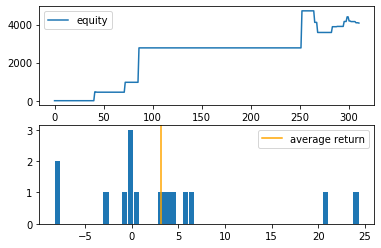

In [9]:
bt = Backtest()
df = data.get_ltf_candles("USDT_BTC", "4-HOUR", "2019-10-12 04:00:00", "2019-12-02 23:00:00").set_index('date')
bt.df = df.merge(funding_rates_df, how='outer', on='date').dropna()
bt.df.rename(columns={"date":"t","low": "L", "high": "H", "open": "O", "close": "C", "volume":'V'}, inplace=True)
bt.df['EMA'] = bt.df['fundingRate'].ewm(span=9, min_periods=9).mean()
bt.sell_exit = bt.buy_entry = (bt.df['EMA'] < 0)
bt.buy_exit = bt.sell_entry = (bt.df['EMA'] > 0)
series = bt.run()
bt.plot()

In [24]:
def automated_backtest(ema_start=1, ema_end=2, iter_list=None):
    """ema_start (int) : Lower bound for the range of the Number of MA days to consider
        ema_end (int) : Upper bound for the range of the Number of MA days to consider
    """
    if not iter_list:
        iter_list = [i for i in range(ema_start, ema_end+1)]
    days = len(iter_list)
    net_profit_df = pd.DataFrame({'ema_day':iter_list,'net_profit':[None]*days,'profit_factor':[None]*days})
    for idx, i in enumerate(iter_list):
        bt.df['EMA'] = bt.df['fundingRate'].ewm(span=i, min_periods=i).mean()
        bt.sell_exit = bt.buy_entry = (bt.df['EMA'] < 0)
        bt.buy_exit = bt.sell_entry = (bt.df['EMA'] > 0)
        series = bt.run()
        net_profit_df['net_profit'].iloc[idx] = series['total profit']
        net_profit_df['profit_factor'].iloc[idx] = series['profit factor']
    return net_profit_df

In [26]:
bt = Backtest()
df = data.get_ltf_candles("USDT_BTC", "4-HOUR", "2019-07-12 04:00:00", "2019-12-02 23:00:00").set_index('date')
bt.df = df.merge(funding_rates_df, how='outer', on='date').dropna()
bt.df.rename(columns={"date":"t","low": "L", "high": "H", "open": "O", "close": "C", "volume":'V'}, inplace=True)
#automated_backtest(iter_list=[9,15,18])
automated_backtest(ema_start=7, ema_end=20)

,ema_day,net_profit,profit_factor
0,7,6291.22600000,2.11500000
1,8,5341.15000000,2.07300000
2,9,4285.77600000,1.79100000
3,10,5685.41100000,2.36100000
4,11,6344.61100000,2.74400000
5,12,6359.56100000,2.83000000
6,13,5201.61900000,2.50000000
7,14,4923.73800000,2.44400000
8,15,6245.41500000,3.92700000
9,16,6474.56500000,4.27600000
